# Statistical Arbitrage in Commodity Futures: A Case Study of Brent and WTI

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
import numpy as np


brent = yf.download("BZ=F", start="2015-01-01", end="2026-01-01")['Close']  # Brent Crude
wti = yf.download("CL=F", start="2015-01-01", end="2026-01-01")['Close']  # WTI Crude

data = pd.DataFrame({'Brent': brent, 'WTI': wti}).dropna()

X = add_constant(data['WTI'])
model = OLS(data['Brent'], X).fit()
beta, intercept = model.params['WTI'], model.params['const']

data['Spread'] = data['Brent'] - (beta * data['WTI'] + intercept)

print(f"Hedge Ratio (beta): {beta:.4f}")
print(f"Intercept: {intercept:.4f}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Hedge Ratio (beta): 1.0077
Intercept: 3.9274


In [2]:
# Rolling Statistics and Z-Scores
rolling_window = 252
data['Spread_Mean'] = data['Spread'].rolling(rolling_window).mean()
data['Spread_Std'] = data['Spread'].rolling(rolling_window).std()
data['Spread_Z'] = (data['Spread'] - data['Spread_Mean']) / data['Spread_Std']

# Signal Generation
volatility_filter = 0.5
data['Valid_Signal'] = abs(data['Spread'].diff()) > volatility_filter
data['Long_Signal'] = (data['Spread_Z'] < -2) & data['Valid_Signal']
data['Short_Signal'] = (data['Spread_Z'] > 2) & data['Valid_Signal']
data['Close_Signal'] = (data['Spread_Z'] > -0.5) & (data['Spread_Z'] < 0.5)

data['Position'] = 0.0
holding_period = 5

In [3]:
data['Position'] = 0.0
holding_period = 5
for i in range(1, len(data)):
    if data['Long_Signal'].iloc[i]:
        data.loc[data.index[i], 'Position'] = 1.0
    elif data['Short_Signal'].iloc[i]:
        data.loc[data.index[i], 'Position'] = -1.0
    elif data['Close_Signal'].iloc[i]:
        data.loc[data.index[i], 'Position'] = 0.0
    else:
        data.loc[data.index[i], 'Position'] = data.loc[data.index[i - 1], 'Position']

In [4]:
data['Spread_Change'] = data['WTI'].diff() - data['Brent'].diff()
trailing_stop_loss = 0.02
data['PnL'] = data['Position'].shift(1) * data['Spread_Change']
data['PnL'] = np.where(data['PnL'] < -trailing_stop_loss, -trailing_stop_loss, data['PnL'])

transaction_cost_per_unit = 0.01
data['Transaction_Cost'] = abs(data['Position'].diff()) * transaction_cost_per_unit
data['Net_PnL'] = data['PnL'] - data['Transaction_Cost']
data['Cumulative_Net_PnL'] = data['Net_PnL'].cumsum()

# Final
total_net_return = data['Cumulative_Net_PnL'].iloc[-1]
sharpe_ratio = (data['Net_PnL'].mean() / data['Net_PnL'].std()) * np.sqrt(252)

print(f"Total Net Return: {total_net_return:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Total Net Return: 141.62
Sharpe Ratio: 0.83


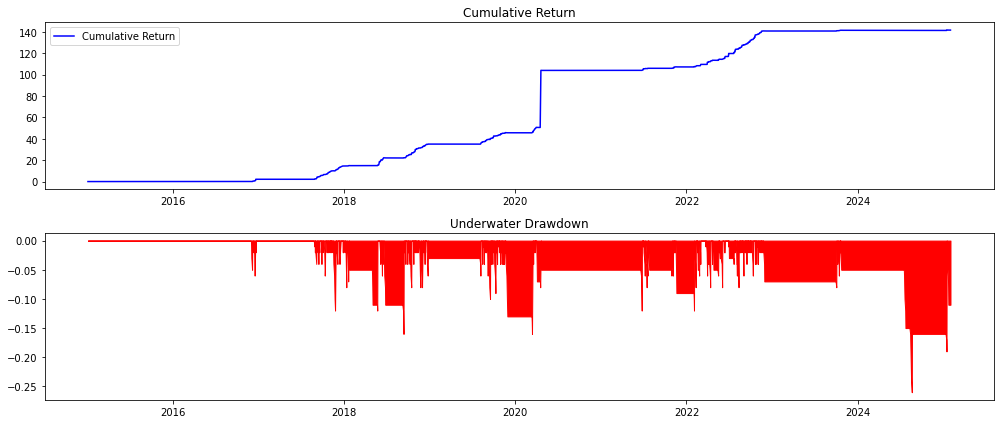

In [5]:
plt.figure(figsize=(14, 6))


plt.subplot(2, 1, 1)
plt.plot(data.index, data['Cumulative_Net_PnL'], label='Cumulative Return', color='b')
plt.title('Cumulative Return')
plt.legend()

data['Peak'] = data['Cumulative_Net_PnL'].cummax()
data['Drawdown'] = (data['Cumulative_Net_PnL'] - data['Peak'])
plt.subplot(2, 1, 2)
plt.fill_between(data.index, data['Drawdown'], color='r')
plt.title('Underwater Drawdown')

plt.tight_layout()
plt.show()

Reference: https://www.cftc.gov/sites/default/files/2022-05/WTIpaper_RP_resubmit_ada.pdf